In [1]:
from IPython import display
%matplotlib inline
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
import time
import torch

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

import tactile_gym.rl_envs
from tactile_gym.sb3_helpers.params import import_parameters

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Make the pushing environment
algo_name = 'ppo'
env_name = 'object_push-v0'
rl_params, algo_params, augmentations = import_parameters(env_name, algo_name)
rl_params["env_modes"][ 'observation_mode'] = 'oracle_data'
print(rl_params)
print(algo_params)

env_kwargs={
    'show_gui':False,
    'show_tactile':False,
    'max_steps':rl_params["max_ep_len"],
    'image_size':rl_params["image_size"],
    'env_modes':rl_params["env_modes"],
}
env = gym.make(env_name, **env_kwargs)

seed = 0
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

# This functions allows the model to evaluate the true rewards given an observation 
reward_fn = reward_fns.cartpole
# This function allows the model to know if an observation should make the episode end
term_fn = termination_fns.cartpole

{'algo_name': 'ppo', 'env_name': 'object_push-v0', 'max_ep_len': 1000, 'image_size': [128, 128], 'env_modes': {'movement_mode': 'TyRz', 'control_mode': 'TCP_velocity_control', 'rand_init_orn': False, 'rand_obj_mass': False, 'traj_type': 'simplex', 'observation_mode': 'oracle_data', 'reward_mode': 'dense'}, 'policy': 'MultiInputPolicy', 'seed': 1, 'n_stack': 1, 'total_timesteps': 1000000, 'n_eval_episodes': 10, 'n_envs': 10, 'eval_freq': 2000.0}
{'policy_kwargs': {'features_extractor_class': <class 'tactile_gym.sb3_helpers.custom.custom_torch_layers.CustomCombinedExtractor'>, 'features_extractor_kwargs': {'cnn_base': <class 'stable_baselines3.common.torch_layers.NatureCNN'>, 'cnn_output_dim': 256, 'mlp_extractor_net_arch': [64, 64]}, 'net_arch': [{'pi': [256, 256], 'vf': [256, 256]}], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>}, 'learning_rate': 0.0003, 'n_steps': 2048, 'batch_size': 64, 'n_epochs': 10, 'gamma': 0.95, 'gae_lambda': 0.9, 'clip_range': 0.2, 'clip_range_vf

pybullet build time: Mar  8 2021 17:26:24


GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) UHD Graphics (TGL GT1)
GL_VERSION=4.6 (Compatibility Profile) Mesa 21.2.6
GL_SHADING_LANGUAGE_VERSION=4.60
Version = 4.6 (Compatibility Profile) Mesa 21.2.6
Vendor = Intel
Renderer = Mesa Intel(R) UHD Graphics (TGL GT1)
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu


In [3]:
print(env.reset())
print(env.get_oracle_obs())
print(type(env.get_oracle_obs()))

[0.000004 0.000006 -0.000006 -0.000013 -0.000009 -0.000002 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.040000 0.000000 0.000000
 0.000000 -0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.090000 0.004401 0.000000 0.000000 0.000000 0.186027]
[0.000004 0.000006 -0.000006 -0.000013 -0.000009 -0.000002 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.040000 0.000000 0.000000
 0.000000 -0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.090000 0.004401 0.000000 0.000000 0.000000 0.186027]
<class 'numpy.ndarray'>


In [4]:
print(env.observation_space)
print(env.action_space)
print(obs_shape)
print(act_shape)

Box(30,)
Box(2,)
(30,)
(2,)


In [5]:
trial_length = 1000
num_trials = 10
ensemble_size = 5

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

In [6]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


In [7]:
replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

In [8]:
common_util.rollout_agent_trajectories(
    env,
    trial_length, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

print("# samples stored", replay_buffer.num_stored)

# samples stored 1000


In [9]:
agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 10,
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 500,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

In [10]:
env.reset()
print("Current goal index", env.targ_traj_list_id)
print("Position goal trajectory", env.traj_pos_workframe)
# print("Orientation goal trajectory", env.traj_rpy_workframe)
# print("Orientation goal trajectory", env.traj_orn_workframe)

# All of this can be accessed through model_env.env
print(model_env.env.targ_traj_list_id)
print(model_env.env.traj_pos_workframe == env.traj_pos_workframe)
print(model_env.env.goal_pos_workframe)

Current goal index 1
Position goal trajectory [[0.065000 0.000000 0.000000]
 [0.090000 0.000392 0.000000]
 [0.115000 0.003561 0.000000]
 [0.140000 0.008435 0.000000]
 [0.165000 0.013438 0.000000]
 [0.190000 0.017397 0.000000]
 [0.215000 0.019991 0.000000]
 [0.240000 0.021086 0.000000]
 [0.265000 0.020561 0.000000]
 [0.290000 0.018393 0.000000]]
1
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[0.090000 0.000392 0.000000]


In [11]:
def termination(act: torch.Tensor, next_obs: torch.Tensor) -> torch.Tensor:
    '''
    Criteria for terminating an episode. Should return a vector of dones of size 
    population_size x batch_size
    '''
    # tcp_pos_workframe = next_obs[:, 0:3]
    # tcp_rpy_workframe = next_obs[:, 3:6]
    # tcp_lin_vel_workframe = next_obs[:, 6:9]
    # tcp_ang_vel_workframe = next_obs[:, 9:12]
    cur_obj_pos_workframe = next_obs[:, 12:15]
    # cur_obj_rpy_workframe = next_obs[:, 15:18]
    # cur_obj_lin_vel_workframe = next_obs[:, 18:21]
    # cur_obj_ang_vel_workframe = next_obs[:, 21:24]
    # pred_goal_pos_workframe = next_obs[:, 24:27]
    # pred_goal_rpy_workframe = next_obs[:, 27:30]

    # Calculate distance between goal and current positon
    obj_goal_pos_dist = torch.linalg.norm(cur_obj_pos_workframe - goal_pos_workframe_batch, axis=1)
    # obj_goal_pos_dist[1] = 0.001

    # intiailise terminated vector
    terminated = torch.zeros((batch_size, 1), dtype=bool)

    # print("goal position batch before update \n", goal_pos_workframe_batch)
    # print("goal index batch before update", targ_traj_list_id_batch)

    # update goals index if subgoal reached
    targ_traj_list_id_batch[obj_goal_pos_dist < model_env.termination_pos_dist] += 1

    # Terminated is true if last subgoal is reached
    terminated[targ_traj_list_id_batch >= model_env.traj_n_points] = True

    # Update goal position batch for none terminated samples
    goal_pos_workframe_batch[~terminated[:,0]] = traj_pos_workframe[targ_traj_list_id_batch[~terminated[:,0]]]
    

    # print("obj to goal distance", obj_goal_pos_dist)
    # print("goal index batch", targ_traj_list_id_batch)
    # print("terminated batch", terminated)
    # print("goal position index not terminated", targ_traj_list_id_batch[~terminated[:,0]])
    # print("The none terminated goals to be updated", traj_pos_workframe[targ_traj_list_id_batch[~terminated[:,0]]])
    # print("The updated goals \n", goal_pos_workframe_batch)
    return terminated

# Reset environment
batch_size = 3
env.reset()
model_env.reset_batch_goals(batch_size)

# Create goal batches (access through model_env)
traj_pos_workframe = model_env.traj_pos_workframe

# goal_pos_workframe = model_env.goal_pos_workframe
# goal_pos_workframe_batch = torch.tile(goal_pos_workframe, (batch_size,) + tuple([1] * goal_pos_workframe.ndim))
goal_pos_workframe_batch = model_env.goal_pos_workframe_batch
# goal_pos_workframe_batch = torch.from_numpy(goal_pos_workframe_batch)

# targ_traj_list_id = model_env.targ_traj_list_id
# targ_traj_list_id_batch = torch.tile(targ_traj_list_id, (batch_size,))
targ_traj_list_id_batch = model_env.targ_traj_list_id_batch
# targ_traj_list_id_batch = torch.from_numpy(targ_traj_list_id_batch).long()
targ_traj_list_id_batch[0] = 11

obs = torch.randn(batch_size, 30)
act = torch.randn(batch_size, 1)
print(termination(act, obs))

# print(model_env.termination_fn(act, obs))
print(model_env.termination(act, obs))

# Test if termination function is same size as original
# obs = torch.randn(2, 4)
# act = torch.randn(2, 1)
# print(term_fn(act, obs))

tensor([[ True],
        [False],
        [False]])
tensor([[ True],
        [False],
        [False]])


In [12]:
from mbrl.util.math import euler_to_quaternion, quaternion_rotation_matrix

def xyz_obj_dist_to_goal(cur_obj_pos_workframe):

    # obj to goal distance
    return torch.linalg.norm(cur_obj_pos_workframe - goal_pos_workframe_batch, axis=1)


def orn_obj_dist_to_goal(cur_obj_rpy_workframe):
    """
    Distance between the current obj orientation and goal orientation.
    """

    # obj to goal orientation
    # cur_obj_orn_workframe = object_push_env._pb.getQuaternionFromEuler(cur_obj_rpy_workframe)
    cur_obj_orn_workframe = euler_to_quaternion(cur_obj_rpy_workframe)
    # obj_goal_orn_dist = np.arccos(np.clip(
    #     (2 * (np.inner(goal_orn_workframe, cur_obj_orn_workframe) ** 2)) - 1, -1, 1))
    inner_product = torch.sum(goal_orn_workframe_batch*cur_obj_orn_workframe, 1)
    return torch.arccos(torch.clip(2 * (inner_product ** 2) - 1, -1, 1))

def cos_tcp_dist_to_obj(cur_obj_rpy_workframe, tcp_rpy_workframe):
    """
    Cos distance from current orientation of the TCP to the current
    orientation of the object
    """
    
    batch_size = cur_obj_rpy_workframe.shape[0]

    # tip normal to object normal
    cur_obj_orn_workframe = euler_to_quaternion(cur_obj_rpy_workframe)
    obj_rot_matrix_workframe = quaternion_rotation_matrix(cur_obj_orn_workframe)
    obj_rot_matrix_workframe = torch.reshape(obj_rot_matrix_workframe, (batch_size, 3, 3))
    obj_init_vector_workframe = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32)
    obj_vector_workframe = torch.matmul(obj_rot_matrix_workframe, obj_init_vector_workframe)
    # obj_vector_workframe = obj_rot_matrix_workframe[:, :, 0]

    tcp_orn_workframe = euler_to_quaternion(tcp_rpy_workframe)
    tip_rot_matrix_workframe = quaternion_rotation_matrix(tcp_orn_workframe)
    tip_rot_matrix_workframe  = torch.reshape(tip_rot_matrix_workframe, (batch_size, 3, 3))
    tip_init_vector_workframe  = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float32)
    tip_vector_workframe  = torch.matmul(tip_rot_matrix_workframe, tip_init_vector_workframe)
    # tip_vector_workframe = tip_rot_matrix_workframe[:, :, 0]

    obj_tip_dot_product = torch.sum(obj_vector_workframe*tip_vector_workframe, 1)
    cos_sim_workfrfame = obj_tip_dot_product / (
        torch.linalg.norm(obj_vector_workframe, axis=1) * torch.linalg.norm(tip_vector_workframe, axis=1)
    )
    cos_dist_workframe = 1 - cos_sim_workfrfame

    return cos_dist_workframe

def reward(act: torch.Tensor, next_obs: torch.Tensor) -> torch.Tensor:
    '''
    Caculate the reward given a batch of observations 
    '''

    batch_size = next_obs.shape[0]

    tcp_pos_workframe = next_obs[:, 0:3]
    tcp_rpy_workframe = next_obs[:, 3:6]
    tcp_lin_vel_workframe = next_obs[:, 6:9]
    tcp_ang_vel_workframe = next_obs[:, 9:12]
    cur_obj_pos_workframe = next_obs[:, 12:15]
    cur_obj_rpy_workframe = next_obs[:, 15:18]
    cur_obj_lin_vel_workframe = next_obs[:, 18:21]
    cur_obj_ang_vel_workframe = next_obs[:, 21:24]
    pred_goal_pos_workframe = next_obs[:, 24:27]
    pred_goal_rpy_workframe = next_obs[:, 27:30]

    obj_goal_pos_dist = xyz_obj_dist_to_goal(cur_obj_pos_workframe)
    obj_goal_orn_dist = orn_obj_dist_to_goal(cur_obj_rpy_workframe)
    tip_obj_orn_dist = cos_tcp_dist_to_obj(cur_obj_rpy_workframe, tcp_rpy_workframe)

    reward = -(obj_goal_pos_dist + obj_goal_orn_dist + tip_obj_orn_dist)
    reward = reward[:, None]

    return reward


# Create observation and goal batch 
batch_size = 2

obs = torch.tensor(env.reset()).to(torch.float32)
model_env.reset_batch_goals(batch_size)

# goal_pos_workframe = torch.tensor(env.goal_pos_workframe).to(torch.float32)
# goal_orn_workframe = torch.tensor(env.goal_orn_workframe).to(torch.float32)
# goal_pos_workframe = model_env.goal_pos_workframe
# goal_orn_workframe = model_env.goal_orn_workframe

obs_batch = torch.tile(obs, (batch_size,) + tuple([1] * obs.ndim))
# goal_pos_workframe_batch = torch.tile(goal_pos_workframe, (batch_size,) + tuple([1] * goal_pos_workframe.ndim))
# goal_orn_workframe_batch = torch.tile(goal_orn_workframe, (batch_size,) + tuple([1] * goal_orn_workframe.ndim))
goal_pos_workframe_batch = model_env.goal_pos_workframe_batch
goal_orn_workframe_batch = model_env.goal_orn_workframe_batch

print(env.dense_reward())
print(reward(_, obs_batch))
print(model_env.reward(_, obs_batch))
# print(model_env.reward_fn(_, obs_batch))

-0.24257249530916758
tensor([[-0.2426],
        [-0.2426]])
tensor([[-0.2426],
        [-0.2426]])


In [13]:
# Test reward and terminal function using next_observ from model.sample()
planning_horizon = agent.optimizer.horizon
# initialise action sequence
action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float()
        )
initial_solution = initial_solution.repeat((planning_horizon, 1))
mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

# Intialise state and create model state for model input
initial_state = env.reset()
tiling_shape = (20 * 500,) + tuple(
    [1] * initial_state.ndim
)
initial_obs_batch = np.tile(initial_state, tiling_shape).astype(np.float32)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)

# get action for time step
action_for_step = action_sequences[:, 0, :]
action_batch = torch.repeat_interleave(
                    action_for_step, 20, dim=0
                )

# Get next observation from model
(
    next_observs,
    pred_rewards,
    pred_terminals,
    next_model_state,
) = model_env.dynamics_model.sample(
    action_batch,
    model_state,
    deterministic=False,
    rng=model_env._rng,
)

# Next obervation types
# print(next_observs.type())
# print(next_observs.dtype)
# print(next_observs.shape)

# Create observation and goal batch 
batch_size = next_observs.shape[0]
model_env.reset_batch_goals(batch_size)

# Get global variables needed for reward function

# If taken from env, need to turn into tensor and float 32
# If taken from model_env, the goals are already converted
# goal_pos_workframe = torch.tensor(env.goal_pos_workframe).to(torch.float32)
# goal_orn_workframe = torch.tensor(env.goal_orn_workframe).to(torch.float32)
# goal_pos_workframe = model_env.goal_pos_workframe
# goal_orn_workframe = model_env.goal_orn_workframe
# goal_pos_workframe_batch = torch.tile(goal_pos_workframe, (batch_size,) + tuple([1] * goal_pos_workframe.ndim))
# goal_orn_workframe_batch = torch.tile(goal_orn_workframe, (batch_size,) + tuple([1] * goal_orn_workframe.ndim))
goal_pos_workframe_batch = model_env.goal_pos_workframe_batch
goal_orn_workframe_batch = model_env.goal_orn_workframe_batch

print(reward(_, next_observs))
print(model_env.reward(_, next_observs))
# print(model_env.reward_fn(_, next_observs))
print(any((reward(_, next_observs) == model_env.reward(_, next_observs))))

# Get the global variables needed for termination function
traj_pos_workframe = model_env.traj_pos_workframe
targ_traj_list_id_batch = model_env.targ_traj_list_id_batch

print(termination(_, next_observs))
print(model_env.termination(_, next_observs))
# print(model_env.termination_fn(act, next_observs))
print(any((termination(_, next_observs) == model_env.termination(_, next_observs))))


tensor([[-4.9670],
        [-2.7816],
        [-2.5193],
        ...,
        [-2.4266],
        [-2.6592],
        [-2.6962]], grad_fn=<UnsqueezeBackward0>)
tensor([[-4.9670],
        [-2.7816],
        [-2.5193],
        ...,
        [-2.4266],
        [-2.6592],
        [-2.6962]], grad_fn=<UnsqueezeBackward0>)
True
tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])
tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])
True


In [14]:
# Test original termination function is same size as original
obs = torch.randn(2, 4)
act = torch.randn(2, 1)
print(reward_fn(act, obs).shape)

torch.Size([2, 1])


In [15]:
# Test evaluation_action_sequences
planning_horizon = agent.optimizer.horizon
# initialise action sequence
# action_lb = env.action_space.low.tolist()
# action_ub = env.action_space.high.tolist()
# initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
#             .float()
#         )
# initial_solution = initial_solution.repeat((15, 1))
# mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
# action_sequences = torch.zeros((500,) + initial_solution.shape)
# action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)
# # print(initial_solution.shape)

# create random action sequences
initial_solution = torch.from_numpy(np.array([env.action_space.sample() for _ in range(planning_horizon)])).float()
# print(initial_solution.shape)
mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

# Initialise environment
initial_state = env.reset()


# evaluate sequences
print(model_env.evaluate_action_sequences(action_sequences, initial_state, 20).shape)

print(any(model_env.targ_traj_list_id_batch!=1))

torch.Size([500])
False


# samples stored 1000
Training time:  3.299402952194214


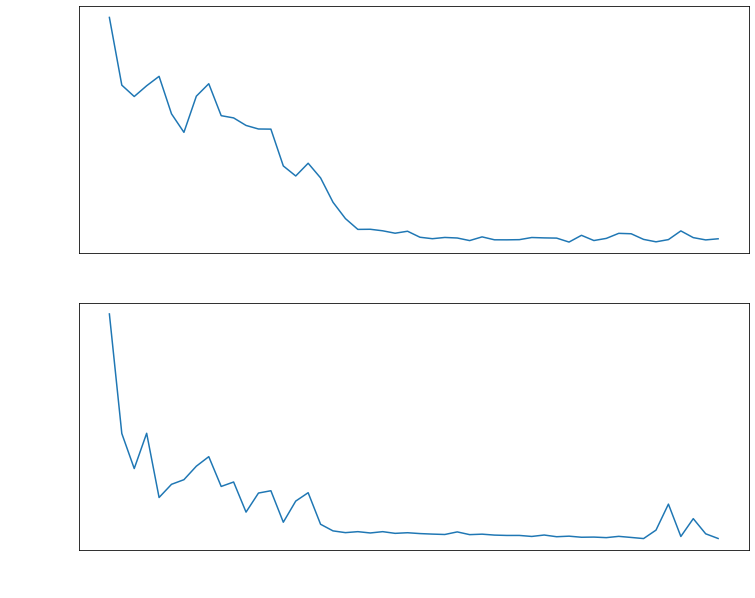

In [20]:
# Test optimisation iterations for CEM
train_losses = []
val_scores = []

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)
common_util.rollout_agent_trajectories(
    env,
    1000, # initial exploration steps
    planning.RandomAgent(env),
    {}, # keyword arguments to pass to agent.act()
    replay_buffer=replay_buffer,
    trial_length=trial_length
)

print("# samples stored", replay_buffer.num_stored)

# Train model first
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)
dynamics_model.update_normalizer(replay_buffer.get_all()) 
dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
    replay_buffer,
    batch_size=cfg.overrides.model_batch_size,
    val_ratio=cfg.overrides.validation_ratio,
    ensemble_size=ensemble_size,
    shuffle_each_epoch=True,
    bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
)

start_train_time = time.time()
model_trainer.train(
    dataset_train, 
    dataset_val=dataset_val, 
    num_epochs=50, 
    patience=50, 
    callback=train_callback,
    silent=True)
train_time = time.time() - start_train_time

print("Training time: ", train_time)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].plot(train_losses)
ax[0].set_xlabel("Total training epochs")
ax[0].set_ylabel("Training loss (avg. NLL)")
ax[0].xaxis.label.set_color('white')
ax[0].yaxis.label.set_color('white')
ax[0].tick_params(axis='x', colors='white')
ax[0].tick_params(axis='y', colors='white')
ax[1].plot(val_scores)
ax[1].set_xlabel("Total training epochs")
ax[1].set_ylabel("Validation score (avg. MSE)")
ax[1].xaxis.label.set_color('white')
ax[1].yaxis.label.set_color('white')
ax[1].tick_params(axis='x', colors='white')
ax[1].tick_params(axis='y', colors='white')
plt.show()

In [25]:
print(dynamics_model.model)

GaussianMLP(
  (hidden_layers): Sequential(
    (0): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=32, out_size=320, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=320, out_size=320, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): EnsembleLinearLayer(num_members=5, in_size=320, out_size=320, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (mean_and_logvar): EnsembleLinearLayer(num_members=5, in_size=320, out_size=60, bias=True)
)


In [93]:
data = replay_buffer.get_all()
print(np.mean(data.obs,0))
print(np.mean(data.rewards))
print(np.mean(data.act, 0))
print(np.mean(data.next_obs, 0))

[0.254889 0.010547 0.000174 0.000381 -0.000328 0.069087 0.002989 0.000542
 0.000008 0.000022 -0.000016 0.001546 0.284304 0.038370 0.000011 -0.000006
 0.000004 0.380074 0.003076 0.000690 -0.000000 -0.000006 -0.000009
 0.002594 0.182651 0.040950 0.000000 0.000000 0.000000 0.625349]
-0.4188507
[0.002582 0.004384]
[0.255189 0.010602 0.000175 0.000382 -0.000330 0.069238 0.002989 0.000552
 0.000008 0.000022 -0.000016 0.001514 0.284600 0.038436 0.000011 -0.000006
 0.000004 0.380290 0.003077 0.000691 -0.000000 -0.000006 -0.000009
 0.002555 0.182751 0.040995 0.000000 0.000000 0.000000 0.625909]


In [94]:
print(data.obs[0])

[0.000004 0.000006 -0.000006 -0.000013 -0.000009 -0.000002 0.000000
 0.000000 0.000000 0.000000 0.000000 0.000000 0.040000 0.000000 0.000000
 0.000000 -0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
 0.000000 0.090000 -0.000134 0.000000 0.000000 0.000000 0.098793]


In [18]:
planning_horizon = agent.optimizer.horizon

# initial_solution = torch.from_numpy(np.array([env.action_space.sample() for _ in range(15)])).float()
# # print(initial_solution.shape)

action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float()
        )
initial_solution = initial_solution.repeat((planning_horizon, 1))

mu, dispersion = agent.optimizer.optimizer._init_population_params(initial_solution)
action_sequences = torch.zeros((500,) + initial_solution.shape)
action_sequences = agent.optimizer.optimizer._sample_population(mu, dispersion, action_sequences)

# Initialise states
initial_state = env.reset()
tiling_shape = (20 * 500,) + tuple(
    [1] * initial_state.ndim
)
initial_obs_batch = np.tile(initial_state, tiling_shape).astype(np.float32)
model_state = model_env.reset(initial_obs_batch, return_as_np=False)
batch_size = initial_obs_batch.shape[0]
total_rewards = torch.zeros(batch_size, 1)
terminated = torch.zeros(batch_size, 1, dtype=bool)
model_env.reset_batch_goals(batch_size)

# get action for time step
# action_for_step = action_sequences[:, 0, :]
# action_batch = torch.repeat_interleave(
#                     action_for_step, 20, dim=0
#                 )

# # Get next observation from model
# _, rewards, dones, model_state = model_env.step(
#             action_batch, model_state, sample=True
#         )
# print(torch.mean((model_state["obs"])))

for time_step in range(10):
    # print(torch.mean(model_state["obs"], 1))
    action_for_step = action_sequences[:, time_step, :]
    action_batch = torch.repeat_interleave(
        action_for_step, 20, dim=0
    )
    _, rewards, dones, model_state = model_env.step(
        action_batch, model_state, sample=True
    )
    rewards[terminated] = 0
    terminated |= dones
    total_rewards += rewards

    # print(torch.mean(action_batch))

# evaluate sequences
# print(model_env.evaluate_action_sequences(action_sequences, initial_state, 20).shape)

# Print rewards for one evaluation
total_rewards = total_rewards.reshape(-1, 20)
final_rewards = total_rewards.mean(dim=1)
print(model_env.goal_pos_workframe_batch)


tensor([[0.0900, 0.0059, 0.0000],
        [0.0900, 0.0059, 0.0000],
        [0.0900, 0.0059, 0.0000],
        ...,
        [0.0900, 0.0059, 0.0000],
        [0.0900, 0.0059, 0.0000],
        [0.0900, 0.0059, 0.0000]])


In [19]:
planning_horizon = agent.optimizer.horizon

obs = env.reset()
agent.reset()
def trajectory_eval_fn(action_sequences):
    return model_env.evaluate_action_sequences(action_sequences, obs, 20)

# Create initial solutions from bounds
action_lb = env.action_space.low.tolist()
action_ub = env.action_space.high.tolist()
initial_solution = (
            ((torch.tensor(action_lb) + torch.tensor(action_ub)) / 2)
            .float()
        )
initial_solution = initial_solution.repeat((planning_horizon, 1))

# # Create random initial solutions
# initial_solution = torch.from_numpy(np.array([env.action_space.sample() for _ in range(15)])).float()

def cem_callback(population, values, i):
    best_values, elite_idx = values.topk(1)
    print("Iteration {}, best value {}".format(i, best_values))

agent.optimizer.optimizer.num_iterations  = 10
# agent.optimizer.optimizer.elite_ratio =
# agent.optimizer.optimizer.population_size = 

# Optimise
agent.optimizer.optimizer.optimize(
            trajectory_eval_fn,
            x0=initial_solution,
            callback=cem_callback,
        )

Iteration 0, best value tensor([-5.7315e+14])
Iteration 1, best value tensor([-1.1836e+15])
Iteration 2, best value tensor([-6.3128e+14])
Iteration 3, best value tensor([-1.1623e+15])
Iteration 4, best value tensor([-3.0751e+14])
Iteration 5, best value tensor([-5.7094e+14])
Iteration 6, best value tensor([-9.3776e+14])
Iteration 7, best value tensor([-6.1733e+14])
Iteration 8, best value tensor([-1.1999e+15])
Iteration 9, best value tensor([-6.0555e+14])


tensor([[ 0.0077,  0.0548],
        [-0.0151,  0.0542],
        [-0.0213, -0.0026],
        [ 0.0002, -0.0548],
        [ 0.0236,  0.0383],
        [ 0.0120, -0.0040],
        [ 0.0065, -0.0416],
        [-0.0266,  0.0161],
        [-0.0506,  0.0282],
        [-0.0097, -0.0366]])

In [21]:
train_losses = [0.0]
val_scores = [0.0]

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model
    

In [22]:
def update_axes(_axs, _frame, _text, _trial, _steps_trial, _plan_time, _train_time, _all_rewards, _train_loss, _val_loss, force_update=False):
    if not force_update and (_steps_trial % 10 != 0):
        return
    _axs[0].imshow(_frame)
    _axs[0].set_xticks([])
    _axs[0].set_yticks([])
    _axs[0].tick_params(axis='x', colors='white')
    _axs[0].tick_params(axis='y', colors='white')
    _axs[1].clear()
    _axs[1].set_xlim([0, num_trials + .1])
    _axs[1].set_ylim([0, 200])
    _axs[1].set_xlabel("Trial")
    _axs[1].set_ylabel("Trial reward")
    _axs[1].xaxis.label.set_color('white')
    _axs[1].yaxis.label.set_color('white')
    _axs[1].tick_params(axis='x', colors='white')
    _axs[1].tick_params(axis='y', colors='white')
    _axs[1].plot(_all_rewards, 'bs-')
    _text.set_text("Trial {}: {} steps\nTrain Loss: {:.2f}\nVal Loss: {:.3g}\nPlan time: {:.2f} s/step\nTrain time: {:.2f} s".format(_trial + 1, _steps_trial, _train_loss, _val_loss, _plan_time, _train_time))
    display.display(plt.gcf())  
    display.clear_output(wait=True)

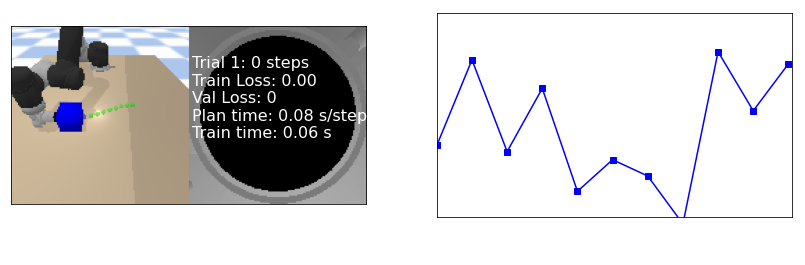

In [35]:
env.reset()
# fig = plt.figure()
# ax = fig.add_subplot()
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# plt.imshow(env.render('rgb_array'))
# plt.grid(False)

# Create visualization objects
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(130, 80, "")
ax_text.set_color('white')
all_rewards = np.random.randint(-10, 200, 11)
plan_time = np.random.rand()
train_time = np.random.rand()
update_axes(axs,env.render(mode="rgb_array"), ax_text, 0, 0, plan_time, train_time, all_rewards, train_losses[-1], val_scores[-1], force_update=True)

KeyboardInterrupt: 

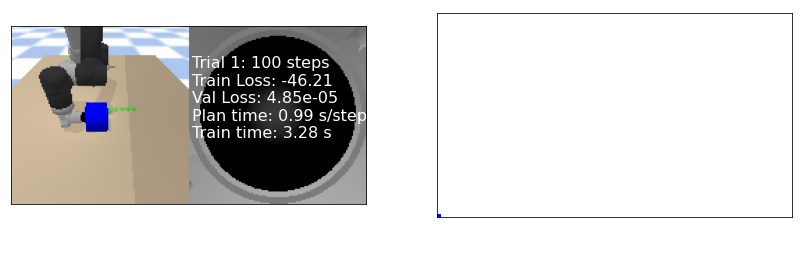

In [37]:
# Create a trainer for the model
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-3, weight_decay=5e-5)

# Create visualization objects
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(130, 80, "")
ax_text.set_color('white')

# Main PETS loop
all_rewards = [0]
plan_time = 0.0
train_time = 0.0
for trial in range(num_trials):
    obs = env.reset()    
    agent.reset()
    
    done = False
    total_reward = 0.0
    steps_trial = 0
    update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, train_time, plan_time, 
        all_rewards, train_losses[-1], val_scores[-1])
    while not done:
        # --------------- Model Training -----------------
        if steps_trial == 0:
            dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats
            
            dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
                replay_buffer,
                batch_size=cfg.overrides.model_batch_size,
                val_ratio=cfg.overrides.validation_ratio,
                ensemble_size=ensemble_size,
                shuffle_each_epoch=True,
                bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement
            )
            
            start_train_time = time.time()
            model_trainer.train(
                dataset_train, 
                dataset_val=dataset_val, 
                num_epochs=50, 
                patience=50, 
                callback=train_callback,
                silent=True)
            train_time = time.time() - start_train_time

        # --- Doing env step using the agent and adding to model dataset ---
        start_plan_time = time.time()
        next_obs, reward, done, _ = common_util.step_env_and_add_to_buffer(
            env, obs, agent, {}, replay_buffer)
        plan_time = time.time() - start_plan_time

        update_axes(
            axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, plan_time, train_time, 
            all_rewards, train_losses[-1], val_scores[-1])
        
        obs = next_obs
        total_reward += reward
        steps_trial += 1
        
        if steps_trial == trial_length:
            break
    
    all_rewards.append(total_reward)

update_axes(axs, env.render(mode="rgb_array"), ax_text, trial, steps_trial, plan_time, train_time, 
    all_rewards, train_losses[-1], val_scores[-1], force_update=True)